# Integration

## Newton-Cotes

3 0.34075853066724404 0.0519405510314801 0.0022798774922103693
5 0.1834653418221377 0.012884199027224597 0.00013458497419382986
9 0.0949599423108507 0.003214828113830337 8.295523967971619e-06
17 0.04828406569741284 0.0008033195149277361 5.166847063531321e-07
33 0.024342886926189244 0.00020080567998093102 3.2265001115305836e-08
65 0.012221646395186303 5.0199907898895724e-05 2.0161288194486815e-09
129 0.006123373269068644 1.2549882473678053e-05 1.2600120946615334e-10
257 0.003064824111058906 3.137464712255067e-06 7.87503395827116e-12
513 0.0015331964220766103 7.843658088590999e-07 4.922728891187944e-13
1025 0.0007667943025135848 1.960914292054028e-07 3.086420008457935e-14
2049 0.00038344617411567583 4.902285577479404e-08 1.9984014443252818e-15


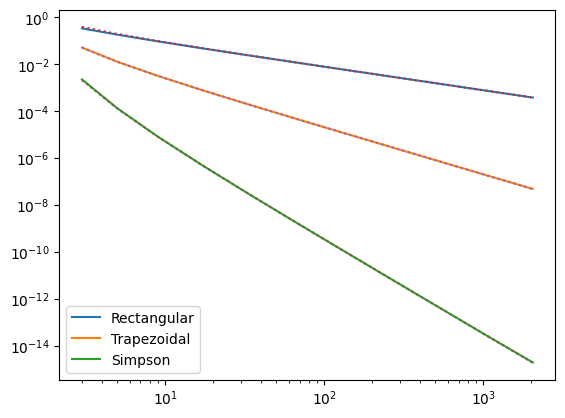

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def do_int(n):
    # integration limits
    x1 = 0.0
    x2 = np.pi/2
    x = np.linspace(x1, x2, n)
    dx = (x2-x1)/(n-1)
    
    # Choose the function to integrate
    if True:
        f = np.cos(x)
        I0 = 1.0
    else: 
        # Polynomial
        a = 4
        I0 = (np.pi/2)**(a+1)/(a+1)  # The analytic value of the integral
        f = x**a  # The function to integrate
    
    I1 = np.sum(f[:-1])*dx    # rectangle rule
    I2 = np.sum(f[1:-1]*dx) + 0.5*dx*(f[0]+f[-1])    # trapzoidal rule
    I3 = np.sum(4*f[1:-1:2]*dx) + np.sum(2*f[2:-1:2]*dx) + f[0]*dx + f[-1]*dx  #simpson's rule
    I3 = I3/3.0
    return abs((I1-I0)/I0), abs((I2-I0)/I0), abs((I3-I0)/I0)

# try different numbers of points, generated as 2^n + 1 so the number is odd
n_vals = [2**(i+1) + 1 for i in range(11)]
err1=np.array([])
err2=np.array([])
err3=np.array([])
for n in n_vals:
    e1, e2, e3 = do_int(n)
    print(n, e1, e2, e3)
    err1 = np.append(err1, e1)
    err2 = np.append(err2, e2)
    err3 = np.append(err3, e3)
    
plt.plot(n_vals, err1, label='Rectangular')
plt.plot(n_vals, err2, label='Trapezoidal')
plt.plot(n_vals, err3, label='Simpson')

n = np.array(n_vals)
dx = (np.pi/2)/(n-1)
# Plot the Euler Maclaurin error formulas
plt.plot(n_vals, dx/2, ":")
plt.plot(n_vals, dx**2/12, ":")
plt.plot(n_vals, dx**4/180, ":")

plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

Notes:
- The scalings with the number of points are $1/N$ for rectangular, $1/N^2$ for trapezoidal, and $1/N^4$ for Simpson's rule. (You might have been expecting $1/N^3$ for Simpson's rule but because of the way it was constructed using double intervals, the third order term is antisymmetric over the double interval and cancels.)
- If you try integrating polynomials, you should find that the error goes to zero (machine precision) for cubic polynomials and below (Simpson), linear or below (trapezoid) or constant (rectangular).
- Some special cases can give surprising results. For example, for $\int \sin^2(x) dx$, all the methods can give exact results. To see why, you can rewrite $\sin^2 x=(1-\cos(2x))/2$. If you have an odd number of sample points, the cos term averages to zero and the remaining term is a constant, which all three methods will fit exactly. 
- It is possible to derive analytic expressions for the errors in the different approximations (these are known as [Euler Maclaurin](https://en.wikipedia.org/wiki/Euler–Maclaurin_formula) formulae). For the trapezoidal rule, the leading term is 
$$\epsilon \approx {1\over 12} (\Delta x)^2 \left[f^\prime(a) - f^\prime(b)\right]$$
and for Simpson's rule,
$$\epsilon \approx {1\over 180} (\Delta x)^4 \left[f^{\prime\prime\prime}(a) - f^{\prime\prime\prime}(b)\right].$$
These are plotted as dotted lines in the Figure, you can see that they agree remarkably well with the numerical results. (Note that when plotting we use the fact that the derivative terms are equal to unity for $\cos(x)$). 

## Gaussian quadrature

quad gives I =   1.493648265624854 1.6582826951881447e-14
1 1 2.0 0.33900332898208696
2 3 1.4330626211475785 -0.0405621898217985
3 5 1.4986795956600294 0.0033684838331537233
4 7 1.4933346224495394 -0.00020998462792936129
5 9 1.493663920702629 1.048110062810725e-05
6 11 1.4936476141506054 -4.361630937756038e-07
7 13 1.493648288869414 1.5562271646873954e-08
8 15 1.4936482648990144 -4.859508274756656e-10
9 17 1.4936482656450039 1.3490379379714472e-11


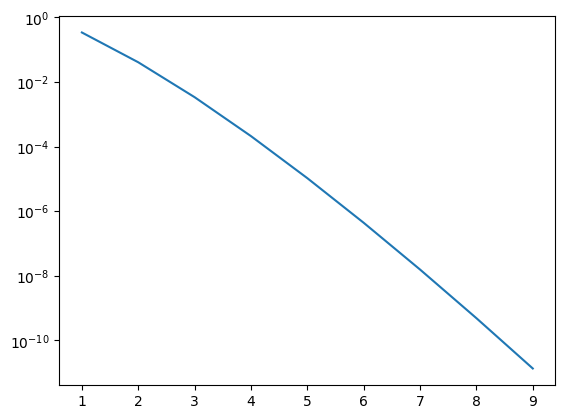

In [5]:
# Use Gaussian quadrature to evalute the integral of polynomials from x=-1 to +1

import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

# Some choices for functions to integrate:
# The first one is a random polynomial (the size parameter sets the degree)
#func = np.polynomial.Polynomial(np.random.randint(-10,high=10,size=20)) 
#func = np.cos
#func = np.exp
func = lambda x: np.exp(-x**2)

# Integrate this with quad to get the true value
I0, err0 = scipy.integrate.quad(func, -1.0, 1.0)
print('quad gives I =  ', I0, err0)

# then use Gaussian quadrature with different numbers of points
n_vec = np.array([])
err_vec = np.array([])

for npoints in range(1,10):
    I = 0.0
    x, w = np.polynomial.legendre.leggauss(npoints)
    for i in range(npoints):
        I += w[i] * func(x[i])
    err = (I-I0)/I0
    print(npoints, 2*npoints-1, I, err)
    n_vec = np.append(n_vec, npoints)
    err_vec = np.append(err_vec, abs(err))
    
plt.plot(n_vec, err_vec)
plt.yscale('log')
plt.xscale('linear')
plt.show()

- You can use the code above to check that the answer is exact for polynomials of degree $2n-1$ and smaller
- The scaling of the error with number of points depends on the function you are integrating, but decreases approximately exponentially (rather than power law with the Newton-Cotes methods).

Let's try the Gauss-Hermite quadrature which has weighting function $W(x)=e^{-x^2}$ for integrals from $-\infty$ to $+\infty$. In the next example I try $x^4 e^{-x^2}$ which becomes exact once we go to 3 terms:

quad gives I =   1.3293403881791366 1.5859180523983767e-08
1 1 0.0 -1.0
2 3 0.4431134627263788 -0.6666666666666666
3 5 1.3293403881791368 1.6703367090890604e-16
4 7 1.3293403881791377 8.351683545445302e-16
5 9 1.3293403881791368 1.6703367090890604e-16
6 11 1.3293403881791355 -8.351683545445302e-16
7 13 1.3293403881791372 5.011010127267181e-16
8 15 1.3293403881791364 -1.6703367090890604e-16
9 17 1.3293403881791372 5.011010127267181e-16


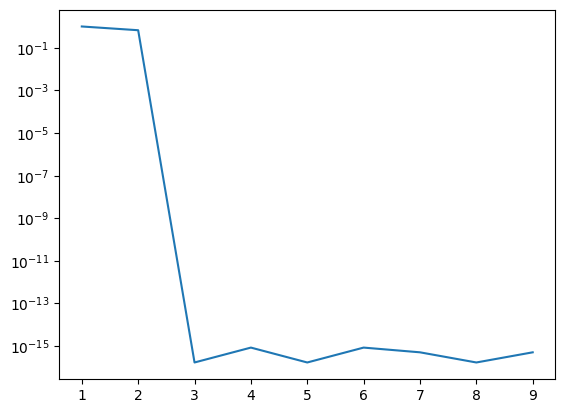

In [3]:
# Gauss-Hermite quadrature

import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

# Function to integrate
func = lambda x: x**4 * np.exp(-x**2)

# Integrate this with quad to get true value
I0, err0 = scipy.integrate.quad(func, -np.inf , np.inf)
print('quad gives I =  ', I0, err0)

# Now try the Gauss-Hermite quadrature with different numbers of points and plot the error
n_vec = np.array([])
err_vec = np.array([])

for npoints in range(1,10):
    I = 0.0
    x, w = np.polynomial.hermite.hermgauss(npoints)
    for i in range(npoints):
        # note that on the next line we include only the part of the function multiplying 
        # the exp(-x^2), because the exp(-x^2) is already taken into account in the weights
        I += w[i] * func(x[i]) /  np.exp(-x[i]**2)  
    err = (I-I0)/I0
    print(npoints, 2*npoints-1, I, err)
    n_vec = np.append(n_vec, npoints)
    err_vec = np.append(err_vec, abs(err))
    
plt.plot(n_vec, err_vec)
plt.yscale('log')
plt.xscale('linear')
plt.show()

## Maxwell-Boltzmann distribution

First summarize some results for the Maxwell-Boltzmann distribution from the Wikipedia page: 

In 1D, the distribution of velocities is

$$f(v)  = \left({m\over 2\pi k_BT}\right)^{3/2} e^{-mv^2/2k_BT} ,$$

which is normalized so that

$$\int_0^\infty d^3v  f(v) =1.$$

The mean speed is

$$\langle v\rangle = \int_0^\infty d^3v\ v f(v).$$

To get this into a simpler form, change integration variable to $x=(m/2k_BT)^{1/2} v$ and use the spherical volume element $d^3 v= 4\pi v^2 dv$. This gives

$$\langle v\rangle = \left({k_BT\over \pi m}\right)^{1/2}\ 4\sqrt{2}\ I\hspace{1cm} I = \int_0^\infty dx\ x^3\ e^{-x^2}.$$

We can evaluate the integral $I$ numerically (aiming for an error of 0.1%). (Spoiler: the analytic answer is 1/2).

For Gaussian quadrature, you might think of using the Gauss-Hermite polynomials since we have an $e^{-x^2}$ in the integral, but the limits are from zero to infinity, not -infinity to infinity. One way to do it is to write the integral as

$${1\over 2}\int_{-\infty}^\infty dx\ \left|x\right|^3\ e^{-x^2}.$$

Note that this is not the same as having a cubic polynomial, so the usual rule about how many terms we need does not apply.

The other way to do it is to rewrite

$$\int_0^\infty dx\ x^3\ e^{-x^2}= \int_0^\infty dy\ {y\over 2} e^{-y}$$

and use Laguerre polynomials.

In [158]:
import numpy as np
import scipy.integrate

func = lambda x: x**3 * np.exp(-x**2)
I0 = 0.5  # the analytic result

# First use quad
# We'll set the relative error we are looking for to 1e-3 and also ask for 
# full output which gives us information such as how many function evaluations were done
I1, err1, info = scipy.integrate.quad(func,0.0,np.inf, full_output=True, epsrel=1e-3)
print("quad gives %lg with error %lg; number of evaluations=%d" % (I1, err1, info['neval']))

# Now Simpson's rule
# Sample the function first
npoints = 21
xp = np.linspace(0.0,7.0,npoints)  # integrate to x=7
fp = func(xp)
I2 = scipy.integrate.simpson(fp, xp)
print("Simpson gives %lg with error %lg; number of points=%d" %(I2, abs(I2-I0)/I0, npoints))

# Now use Gaussian quadrature
npoints = 15
x, w = np.polynomial.hermite.hermgauss(npoints)
I3 = 0.5 * np.sum(w * abs(x)**3)
print("Gauss-Hermite gives %lg with error %lg; number of terms=%d" %(I3, abs(I3-I0)/I0, npoints))

# Gauss-Laguerre
npoints = 1
x, w = np.polynomial.laguerre.laggauss(npoints)
I4 = 0.5 * np.sum(w * x)
print("Gauss-Laguerre gives %lg with error %lg; number of terms=%d" %(I4, abs(I4-I0)/I0, npoints))



quad gives 0.5 with error 3.36729e-05; number of evaluations=75
Simpson gives 0.499296 with error 0.00140896; number of points=21
Gauss-Hermite gives 0.500992 with error 0.0019831; number of terms=15
Gauss-Laguerre gives 0.5 with error 0; number of terms=1


In the Simpson's method, we integrate to $x=7$. You can experiment with this and see how much it changes the answer. At $x=7$, the integrand becomes comparable to the machine precision, so it seems a reasonable place to stop.